In [82]:
# Learning Resources:
#  - https://www.pythonguis.com/tutorials/tkinter-basic-widgets/
#  - https://www.tcl-lang.org/man/tcl8.6/TkCmd/contents.htm
#  - https://www.tutorialspoint.com/python/python_gui_programming.htm
#  - https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html#

In [83]:
import tkinter as tk
from tkinter import ttk
from ttkthemes import ThemedTk
import yfinance as yf
import pandas as pd
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.dates as mdates

In [84]:
class guiWindow:
    def __init__(self):
        self.root = ThemedTk(theme="breezedark")
        self.frames={}
        self.frame_count = 0
        self.nested_frame_count = 0
        self.stock_data = None
        self.stock_tickers = []

        # Additional configuration
        self.root.title("stockr")
        self.root.minsize(255,330)
        self.root.maxsize(2550,3300)
        self.root.geometry("1200x800")
        # self.root.configure(background='lightgrey')

In [85]:
class guiVisuals:
    def __init__(self, guiWindow, type:str, ticker:str, target_frame=None):
        self.guiWindow = guiWindow
        self.type = type.lower()
        self.ticker = ticker
        if target_frame is not None and target_frame in guiWindow.frames:
            self.target_frame = guiWindow.frames[target_frame]
        else:
            self.target_frame = guiWindow.root
        self.stock_data = guiWindow.stock_data[f"{ticker}_data"]
        self.stock_data.reset_index(inplace=True)  # Ensure the index is reset for consistent access
        self.dispatch_type()
    
    def dispatch_type(self):
        # Redirect type parameter to visual call
        method_name = f"create_{self.type}"
        method = getattr(self, method_name, None)
        if method:
            method()
        else:
            print(f"[Warning]: Visuals visual type '{self.type}' not yet implemented.")

    def create_label(self):
        # Create a label
        self.label = tk.Label(self.guiWindow.root, text="testing label!", font=('Helvetica', 19))
        self.label.pack()
        return self.label
        # Return to calibrate positioning!

    def create_table(self):
        style = ttk.Style()

        style.configure("Treeview",
                        font=("Helvetica", 10),
                        rowheight=22,
                        background="#f8f9fa",
                        fieldbackground="#f8f9fa",
                        foreground="black")

        style.configure("Treeview.Heading",
                        font=("Helvetica", 10, "bold"),
                        background="#dee2e6",
                        foreground="black")

        style.map("Treeview", background=[("selected", "#cce5ff")])
        style.configure("Treeview.Row", padding=1)

        tree = ttk.Treeview(self.target_frame)
        tree["columns"] = list(self.stock_data.columns)
        tree["show"] = "headings"

        tree.tag_configure("evenrow", background="#ffffff")
        tree.tag_configure("oddrow", background="#e9ecef")

        for col in self.stock_data.columns:
            width = max(80, min(150, int(self.stock_data[col].astype(str).map(len).mean() * 7)))
            tree.column(col, anchor="center", width=width)
            tree.heading(col, text=col)

        for i, (_, row) in enumerate(self.stock_data.iterrows()):
            tag = "evenrow" if i % 2 == 0 else "oddrow"
            tree.insert("", "end", values=list(row), tags=(tag,))

        tree.pack(fill='both', expand=True)

    def create_line_chart(self):
        df = self.stock_data.copy()
        df["Average Price"] = (df["High"] + df["Low"]) / 2

        fig, ax = plt.subplots(figsize=(8, 4))

        line, = ax.plot(df["Date"], df["Average Price"],
                        label="Average Price",
                        color="steelblue",
                        linewidth=1.5,
                        marker="o" if len(df) <= 62 else None)

        ax.set_ylabel("Average Price (USD)")
        ax.grid(True)
        fig.autofmt_xdate()

        # Reduce tick clutter and font size
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax.yaxis.set_major_locator(plt.MaxNLocator(8))
        ax.tick_params(axis='both', labelsize=8)

        canvas = FigureCanvasTkAgg(fig, master=self.target_frame)
        canvas.get_tk_widget().pack(fill="both", expand=True)

In [86]:
class guiInteractables:
    def __init__(self, guiWindow, type, target_frame, padx=None, pady=None, side=None, 
                 fill=None, entry_text=None, on_submit=None,function=None):
        self.guiWindow = guiWindow
        self.type = type.lower()
        if target_frame is not None and target_frame in guiWindow.frames:
            self.target_frame = guiWindow.frames[target_frame]
        else:
            self.target_frame = guiWindow.root
        self.padx = padx
        self.pady = pady
        self.side = side
        self.fill = fill
        self.entry_text = entry_text if entry_text else "You forgot input text!"

        self.on_submit = on_submit
        self.function = function    # per widget
        
        self.dispatch_type()

    def dispatch_type(self):
        method_name = f"create_{self.type}"
        method = getattr(self, method_name, None)
        if method:
            method()
        else:
            print(f"[Warning]: Interactable visual type '{self.type}' not yet implemented.")
    
    def handle_submit(self, event=None):  # <-- must accept event
        value = self.entry.get()
        if callable(self.function):
            self.function(value)
        if callable(self.on_submit):
            self.on_submit(value)
        self.entry.delete(0, tk.END)
# ----------------------------------------------------------------------------------------------------------
    def create_entry(self):
        self.entry = tk.Entry(self.target_frame, width=30)
        self.entry.insert(0, string=self.entry_text)
        self.entry.bind("<Return>", self.handle_submit)
        self.entry.pack(padx=self.padx, pady=self.pady, side=self.side, fill=self.fill)
        return self.entry
# ----------------------------------------------------------------------------------------------------------
    def create_combobox(self):
        self.combobox = ttk.Combobox(self.target_frame, width=30)
        self.combobox['values'] = self.guiWindow.stock_tickers
        # self.combobox.bind("<<ComboboxSelected>>", func=self.handle_submit)
        self.combobox.set(self.entry_text)
        self.combobox.pack(padx=self.padx, pady=self.pady, side=self.side, fill=self.fill)
        return self.combobox

In [87]:
class guiFrames:
    def __init__(self, guiWindow, width=800, height=600, parent_frame=None,
                 use_place=False, relx=None, rely=None, anchor=None, x=None, y=None,
                 padx=None, pady=None, side=None, fill=None, bg="red"):
        self.guiWindow = guiWindow
        self.width = width
        self.height = height
        self.parent_frame = parent_frame
        self.use_place = use_place
        self.bg = bg

        # Placement parameters
        self.relx = relx
        self.rely = rely
        self.anchor = anchor
        self.x = x # padding for parent frames
        self.y = y # padding for parent frames
        self.side = side
        self.fill = fill

        self.name = None
        self.create_frame()

    def create_frame(self):
        parent = self.guiWindow.frames[self.parent_frame] if self.parent_frame in self.guiWindow.frames else self.guiWindow.root

        if parent == self.guiWindow.root:
            self.frame = tk.Frame(parent, bg='blue', width=self.width, height=self.height)
        else:
            self.frame = tk.Frame(parent, bg=self.bg, width=self.width, height=self.height)
        self.frame.pack_propagate(False)

        if self.use_place and self.relx is not None and self.rely is not None:
            self.frame.place(
                relx=self.relx, rely=self.rely, anchor=self.anchor, x=self.x, y=self.y,)
        else:
            # Default to `pack` layout (call this an error)
            self.frame.pack(anchor="center")

        # Register frame
        if parent == self.guiWindow.root:
            self.guiWindow.frame_count += 1
            self.name = f"frame_{self.guiWindow.frame_count}"
        else:
            self.guiWindow.nested_frame_count += 1
            self.name = f"nested_frame_{self.guiWindow.nested_frame_count}"

        self.guiWindow.frames[self.name] = self.frame
        return self.frame

In [88]:
class dataOperations:
    def __init__(self, tickers, start_date, end_date, interval="60m"):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.stock_data = {}

    def fetch_stock_data(self):
        """
        Note: plucked from old project, modified as needed. Fetch stock data for given tickers and date range.
        
        Args:
            tickers (list): List of stock ticker symbols (e.g., ['AAPL', 'MSFT']).
            start_date (str): Start date (e.g., '2024-10-01').
            end_date (str): End date (e.g., '2024-10-31').
            interval (str): Interval for data download, recommended entries: 30m, 60m, 1d, 1wk, 1mo.
        
        Returns:
            dict: Dictionary with ticker keys and their data as values, and a list of tickers.
        """
        for ticker in self.tickers:
            # Download data for each ticker
            data = yf.download(
                ticker, start=self.start_date, end=self.end_date, interval=self.interval, rounding=True)
            self.stock_data[f"{ticker}_data"] = data
            self.stock_data["tickers"] = self.tickers
        
        guiWindow.stock_data = self.stock_data  # Update the stock_data in guiWindow
        return self.stock_data
    
    def correct_stock_data(self, stock_data):
        """
        Clean and standardize stock data:
        - Flattens multi-index if needed
        - Renames the index column to 'Date'
        - Formats date to exclude seconds
        - Drops time entirely if it's midnight (daily interval)
        """
        for ticker_key, df in stock_data.items():
            if ticker_key == "tickers":
                continue

            if isinstance(df.columns, pd.MultiIndex):
                df = df.droplevel("Ticker", axis=1)

            df = df.reset_index()
            df.rename(columns={df.columns[0]: "Date"}, inplace=True)

            # Format 'Date' column depending on time presence
            if pd.api.types.is_datetime64_any_dtype(df["Date"]):
                if (df["Date"].dt.time == pd.Timestamp("00:00").time()).all():
                    df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')  # Drop time if it's all midnight (daily/monthly data)
                else:
                    df["Date"] = df["Date"].dt.strftime('%Y-%m-%d %H:%M')  # Keep hours + minutes

            df.columns.name = "Data Index"
            stock_data[ticker_key] = df

        guiWindow.stock_data = stock_data
        return stock_data

In [89]:
# Define data request
data_op = dataOperations(
    tickers=["AAPL", "MSFT",],
    start_date="2025-06-01",
    end_date="2025-06-30",
    interval="60m")

/var/folders/yt/068k7p4x3934d27j929_47ww0000gn/T/ipykernel_60563/1336210606.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/yt/068k7p4x3934d27j929_47ww0000gn/T/ipykernel_60563/1336210606.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


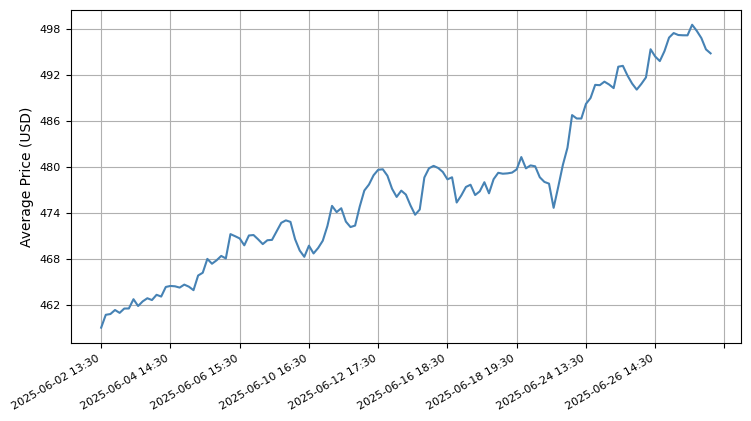

In [90]:
# Fetch and assign data
window = guiWindow()
window.stock_data = data_op.fetch_stock_data()
window.stock_data = data_op.correct_stock_data(window.stock_data)
# ----------------------------------------------------------------------------------------------------------
# Frame Setup
        # Parent frames -> sum = 1135
main_frame = guiFrames(window, width=875, height=500, use_place=True, relx=1, rely=0, anchor='ne', x=-20, y=20)
main_toggle_frame = guiFrames(window, width=260, height=500, use_place=True, relx=0, rely=0, anchor='nw', x=20, y=20)
main_supplementary_frame = guiFrames(
    window, width=840, height = 240, use_place = True, relx=0, rely=1, x=20, y=-20, anchor='sw')
main_news_frame = guiFrames(
    window, width=295, height=240, use_place=True, relx=1, rely=1, x=-20, y=-20, anchor='se')

        # Nested frames
table_frame = guiFrames(
    window, width=865, height=490, parent_frame=main_frame.name, use_place=True, anchor='center',relx=0.5, rely=0.5, bg='red')
toggle_frame = guiFrames(window, width=250, height=490, parent_frame=main_toggle_frame.name, use_place=True,
    anchor='center', relx=0.5, rely=0.5, bg='orange')
supplementary_frame = guiFrames(window, width=830, height=230, parent_frame=main_supplementary_frame.name,
    use_place=True, anchor='center', relx=0.5, rely=0.5, bg='green')
news_frame = guiFrames(window, width=285, height=230, parent_frame=main_news_frame.name, use_place=True,
    anchor='center', relx=0.5, rely=0.5, bg='yellow')
# ----------------------------------------------------------------------------------------------------------
# Interactables setup
    # Stock history
stock_history_widget = guiInteractables(
    window, type="combobox", target_frame=toggle_frame.name, padx=10, pady=10, side="top", fill="x", 
    entry_text="Select from History",)

    # Stock selection
def add_ticker(value):
    ticker = value.strip().upper()
    if ticker and 1 <= len(ticker) <= 6 and ticker not in window.stock_tickers:
        window.stock_tickers.append(ticker)
        stock_history_widget.combobox['values'] = window.stock_tickers # update history

stock_selection_widget = guiInteractables(
    window, type="entry", target_frame=toggle_frame.name, padx=10, pady=10, side="top", fill="x", 
    entry_text="Input (e.g. AAPL)", function=add_ticker, on_submit=None)
# ----------------------------------------------------------------------------------------------------------
# Load frames
guiVisuals(window, type="line_chart", ticker="MSFT", target_frame=table_frame.name)

# Run main loop
window.root.mainloop()